In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd.functional import hessian
from torch.autograd.functional import jacobian as jac
import progressbar
tod = torch.distributions
from tensorflow.keras.utils import Progbar
import pkbar
from torch.distributions import Categorical

import hessianestimate
from hessianestimate.hessian import Condpf
import hessianestimate.hessian as hessestimate

In [2]:
"""
An example of how to initialize a Partially Observed Diffusion Process with Discrete Observation
Model (PODPDO). Here we initializes a FitzHugh–Nagumo Model as in the simulation section of our paper.
"""

class PODPDO(torch.nn.Module):

    # dx=dy=2
    def __init__(self):
        super().__init__()
        "let us try to use theta as a tensor instead"
        self.theta = torch.tensor([1.0,0.2,0.4,0.5])
        #self.theta = torch.nn.Parameter(torch.tensor([1.0,1.0,1.0,0.04]))
        self.sig = torch.tensor([0.2,0.4])
    
    # Drift function: x shape [N, dx] or [-1, dx] in python language
    def mu(self, x):
        drift_coef = torch.zeros_like(x)
        drift_coef[:,0] = self.theta[0] * (x[:,0] - x[:,0]**3 - x[:,1])
        drift_coef[:,1] = self.theta[1] * x[:,0] - x[:,1] + self.theta[2]
        return drift_coef

    # Diffusion function: x shape [N, dx] or [-1, dx] in python language
    def sigma(self, x):
        return (self.sig * torch.eye(x.shape[-1])).repeat(x.shape[0],1,1)
    
    # log PDF of Y_t|X_t : x shape [N, dx] y shape [dy]
    def likelihood_logscale(self, x, y):
        dist_yx = tod.MultivariateNormal(loc=x, covariance_matrix=torch.eye(y.shape[-1])*self.theta[3]**2)
        gn = dist_yx.log_prob(y)
        return gn
    
    # Distribution of Y_t|X_t: x shape [N, dx] or [-1, dx] in python language
    def dist_yx(self, x):
        dist_yx = tod.MultivariateNormal(loc=x, covariance_matrix=torch.eye(x.shape[-1])*self.theta[3]**2)
        return dist_yx

In [3]:
l = 4
T = 5
N = 50
dx = 2
dy = 2
initial_val = 1
param = [l,T,N,dx,dy,initial_val]

In [4]:
fhn = PODPDO()
cond = Condpf(fhn, param)
cond1 = Condpf(fhn, param)
cond1.l = 6

# record True theta Value
theta_true = cond.model.theta

# training data generation
train_data = []
for i in range(100):
    ini_path = cond.initial_path_gen()
    observe_path = cond.model.dist_yx(ini_path).sample()[0::2**l]
    train_data.append(observe_path)
    
train_data_new = []
for i in range(100):
    ini_path = cond1.initial_path_gen()
    observe_path = cond1.model.dist_yx(ini_path).sample()[0::2**(l+2)]
    train_data_new.append(observe_path)

In [13]:
'M=100 for the R&G estimate of Hessian of loglikelihood of observations from time 1 to T'
hessestimate.RGhessian(cond, observe_path, 100)

R&G estimate of Hessian calculating
100/100  [============] - 31.0s


tensor([[  8.5317,  -6.7877,  -6.8949,  15.9412],
        [ -6.7877,  -9.5827,   2.4302,  -1.2907],
        [ -6.8949,   2.4302, -11.5650,  -5.3529],
        [ 15.9412,  -1.2907,  -5.3529, -40.2799]])

In [26]:
"""
For general PODPDO model, analytical solution of Hessian is not possible, to verify the
approach, note that the estimation of score function is essentially obtained similarly, 
and a correct estimation combined with SGD ensures that we can learn the true parameter
theta. Which is what we will do here
"""

"SGD algorithm"
def SGD_estimate_grad(theta_train, condpf, data, epsilon_g=0.001, alpha=0.001):
    condpf.model.theta = theta_train
    grad_val = -hessestimate.score_est(condpf, data, rep_num=200)
    converge = (torch.max(abs(grad_val)) < epsilon_g)
    ## search direction normalized vector
    p = - grad_val
    theta_train = theta_train + p * alpha
    # for general model, we will not be able to get the 'loss' function
    return theta_train, converge, grad_val

In [ ]:
"Trainig Loop for SGD"

theta_train = torch.tensor([0.8,0.8,0.8,0.8])

metrics_names = ['acc']
epochs = 8
num_training_data = len(train_data_new)
theta_vals = torch.zeros((epochs*num_training_data, theta_true.shape[0]))
converge_time = []
meet_converg = False

for i in range(epochs):
    kbar = pkbar.Kbar(target=len(train_data_new), epoch=i, num_epochs=epochs, width=12)
    
    for j, single_data in enumerate(train_data_new):
        # train step
        theta_train, converge, grad_value = SGD_estimate_grad(theta_train, cond, single_data)
        # convergence threshold
        if hessestimate.acc_param(theta_true, theta_train) > 0.92:
            converge_time.append(len(train_data_new)*i + j)
            meet_converg = True
        # Set the terminate mechanism. stop training once convergence is reached
        if meet_converg:
            break
        theta_vals[i*num_training_data+j] = theta_train
        
        kbar.update(j,values=[('theta acc', hessestimate.acc_param(theta_true,theta_train))])
    # Set the terminate mechanism, stop training once convergence is reached
    if meet_converg:
        break
    kbar.add(1)
    
plt.plot(theta_vals[:,0], label='learned $theta_{1}$')
plt.plot(theta_vals[:,1], label='learned $theta_{2}$')
plt.plot(theta_vals[:,2], label='learned $theta_{3}$')
plt.plot(theta_vals[:,3], label='learned $theta_{4}$')

plt.axhline(y=theta_true[0], color='k', linestyle=':')
plt.axhline(y=theta_true[1], color='k', linestyle='--')
plt.axhline(y=theta_true[2], color='k', linestyle=':')
plt.axhline(y=theta_true[3], color='k', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Trained values')
plt.title('SGD Convergence Plot')
plt.legend()
plt.show()
print('Convergence reached at iteration',converge_time[0])

Previous Results: Convergence reached at iteration 714, training successful.

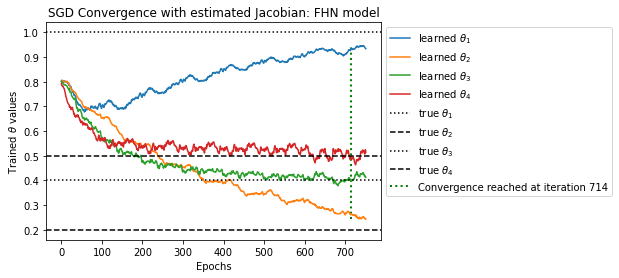

In [28]:
"Newton algorithm"
def Newton_estimate(theta_train, condpf, data, epsilon_g=0.001, alpha=0.001):
    condpf.model.theta = theta_train
    grad_val = - hessestimate.score_est(condpf, data, rep_num=200)
    hess_val = - hessestimate.hessian_data_logprob_est(condpf, data, rep_num=200)
    ## search direction normalized vector
    step = torch.inverse(hess_val) @ torch.unsqueeze(grad_val, axis=1)
    step = torch.squeeze(step)
    theta_train = theta_train + step * alpha  
    return theta_train

In [ ]:
"""
Note that Newton method admits only local convergence, so its performance depends on proper
choice of initial position of training parameter, as well as the observations. This cell thus
does has stable training effect

More stable 2nd order optimization scheme can be applied with our Hessian estimation to obtain 
better training speed for unknown parameter for PODPDO models.
"""

theta_train = torch.tensor([0.8,0.8,0.8,0.8])

metrics_names = ['acc']
epochs = 8
num_training_data = len(train_data_new)
theta_vals = torch.zeros((epochs*num_training_data, theta_true.shape[0]))
converge_time = []
meet_converg = False

for i in range(epochs):
    kbar = pkbar.Kbar(target=len(train_data_new), epoch=i, num_epochs=epochs, width=12)
    
    for j, single_data in enumerate(train_data_new):
        # train step
        theta_train = Newton_estimate(theta_train, cond, single_data)
        # convergence threshold
        if acc_param(theta_true, theta_train) > 0.92:
            converge_time.append(len(train_data_new)*i + j)
            meet_converg = True
        # Set the terminate mechanism. stop training once convergence is reached
        if meet_converg:
            break
        theta_vals[i*num_training_data+j] = theta_train
        
        kbar.update(j,values=[('theta acc', acc_param(theta_true,theta_train))])
    # Set the terminate mechanism, stop training once convergence is reached
    if meet_converg:
        break
    kbar.add(1)
    
plt.plot(theta_vals[:,0], label='learned $theta_{1}$')
plt.plot(theta_vals[:,1], label='learned $theta_{2}$')
plt.plot(theta_vals[:,2], label='learned $theta_{3}$')
plt.plot(theta_vals[:,3], label='learned $theta_{4}$')

plt.axhline(y=theta_true[0], color='k', linestyle=':')
plt.axhline(y=theta_true[1], color='k', linestyle='--')
plt.axhline(y=theta_true[2], color='k', linestyle=':')
plt.axhline(y=theta_true[3], color='k', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Trained values')
plt.title('Newton Convergence Plot')
plt.legend()
plt.show()
print('Convergence reached at iteration',converge_time[0])